In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
def pre_processing(adata, min_num=100):
    # filter gene expressed proportion is  less than 0.1% in all cell
    # sc.pp.filter_genes(adata, min_cells=0.001*len(adata.obs))
    
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    adata.var['rb'] = adata.var_names.str.contains('^RP[SL]')
    adata.var['hb'] = adata.var_names.str.contains('^HB[APS]')
    adata.var['hsp'] = adata.var_names.str.contains('^HSP')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rb','hb','hsp'], percent_top=None, log1p=False, inplace=True)
    
    sc.pp.filter_cells(adata, min_genes=min_num)
    # sc.pp.filter_genes(adata, min_cells=10)
    
    adata = adata[adata.obs.total_counts > 300, :]
    adata = adata[adata.obs.total_counts < 20000, :]
    adata = adata[adata.obs.pct_counts_mt < 20, :]
    adata = adata[adata.obs.pct_counts_hb < 5, :]
    
    adata.layers["raw"] = adata.X.copy()
    
    return adata

def normalization(adata, n_top = 2000):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=n_top)
    #adata = adata[:, adata.var.highly_variable]
    #sc.pp.regress_out(adata, ['total_counts', 'n_genes_by_counts', 
    #                          'pct_counts_mt', 'pct_counts_hsp'])
    sc.tl.pca(adata, svd_solver='arpack')
    return adata

def umap(adata, resolution=0.5, umap_x=None):
    sc.pp.neighbors(adata, use_rep=umap_x)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, n_iterations=-1)
    return adata

In [4]:
dir_path = Path("/mnt/d/dailywork/02_ctc/data")
adata = sc.read_h5ad(dir_path / 'Y00722F7/Y00722F7.h5ad')
ref_adata = sc.read_h5ad(dir_path / "C03427D4.h5ad")

In [5]:
print(ref_adata)
print(adata)

AnnData object with n_obs × n_vars = 993 × 25994
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 387 × 32187
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'


In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['rb'] = adata.var_names.str.contains('^RP[SL]')
adata.var['hb'] = adata.var_names.str.contains('^HB[APS]')
adata.var['hsp'] = adata.var_names.str.contains('^HSP')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rb','hb','hsp'], percent_top=None, log1p=False, inplace=True)

In [7]:
adata.obs['n_genes_by_counts'].median()

306.0

In [8]:
ref_adata = pre_processing(ref_adata)
adata = pre_processing(adata)

/tmp/ipykernel_3713/3279295976.py:19: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  adata.layers["raw"] = adata.X.copy()
/tmp/ipykernel_3713/3279295976.py:19: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  adata.layers["raw"] = adata.X.copy()


In [9]:
ref_adata

AnnData object with n_obs × n_vars = 893 × 25994
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'n_genes'
    var: 'mt', 'rb', 'hb', 'hsp', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'
    layers: 'raw'

In [10]:
adata

AnnData object with n_obs × n_vars = 239 × 32187
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'n_genes'
    var: 'mt', 'rb', 'hb', 'hsp', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'
    layers: 'raw'

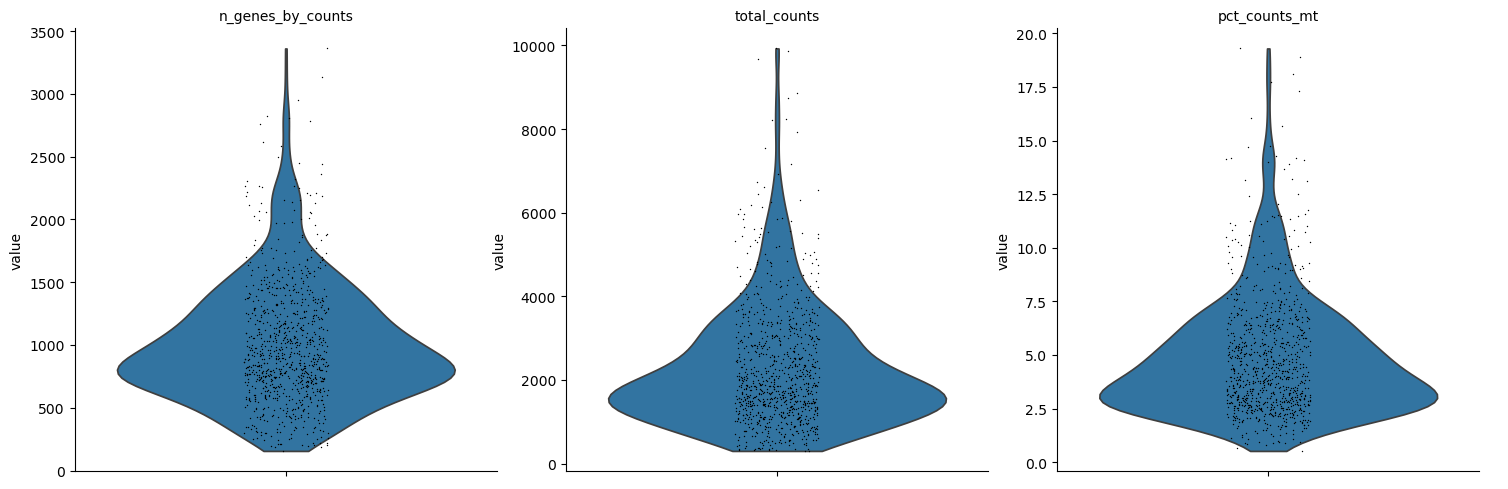

In [11]:
sc.pl.violin(ref_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True)

In [12]:
ref_adata = normalization(ref_adata)

In [13]:
ref_adata = umap(ref_adata, resolution=0.6)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3713/3279295976.py:36: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution, n_iterations=-1)


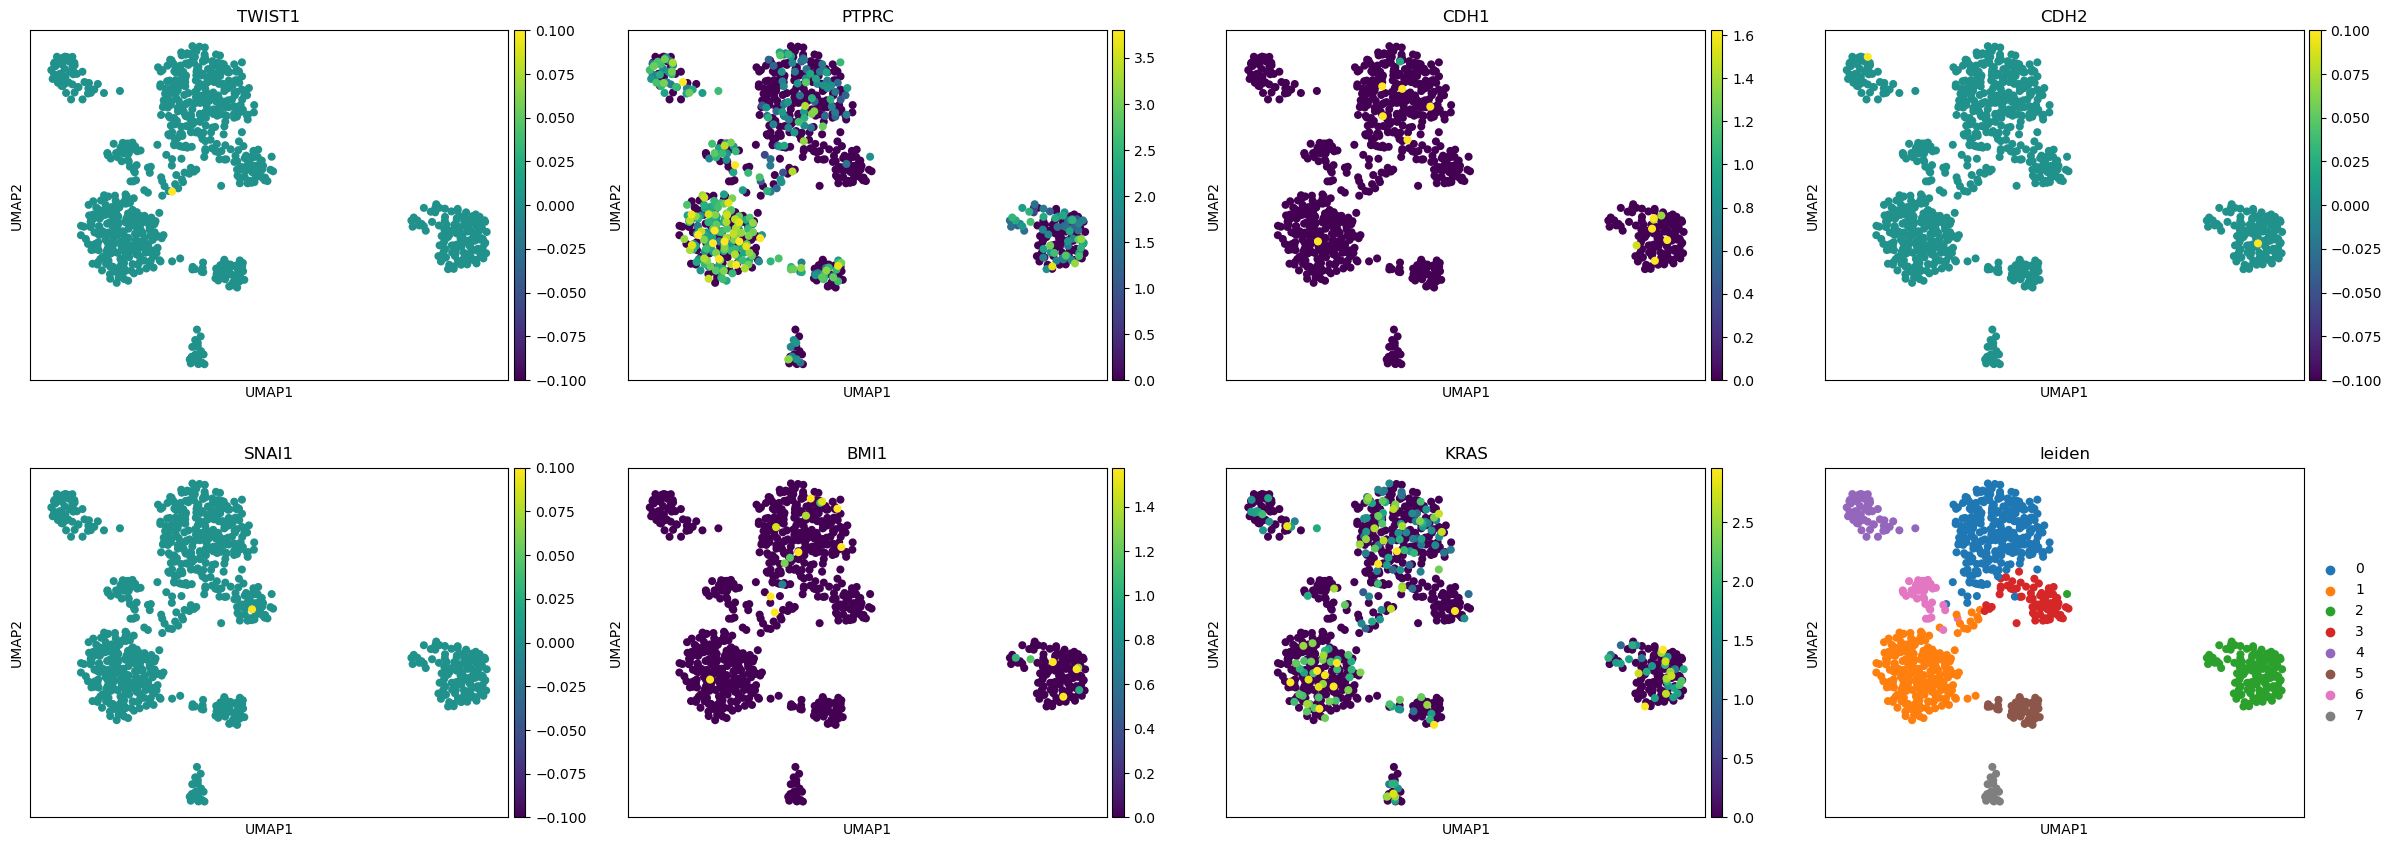

In [14]:
sc.pl.umap(ref_adata, color=['TWIST1', 'PTPRC', 'CDH1', 'CDH2', 'SNAI1', 'BMI1', 'KRAS', 'leiden'], vmax='p99', vmin='p1')

In [15]:
adata = normalization(adata)
adata = umap(adata)

In [16]:
adata.obs['n_genes_by_counts'].median()

401.0

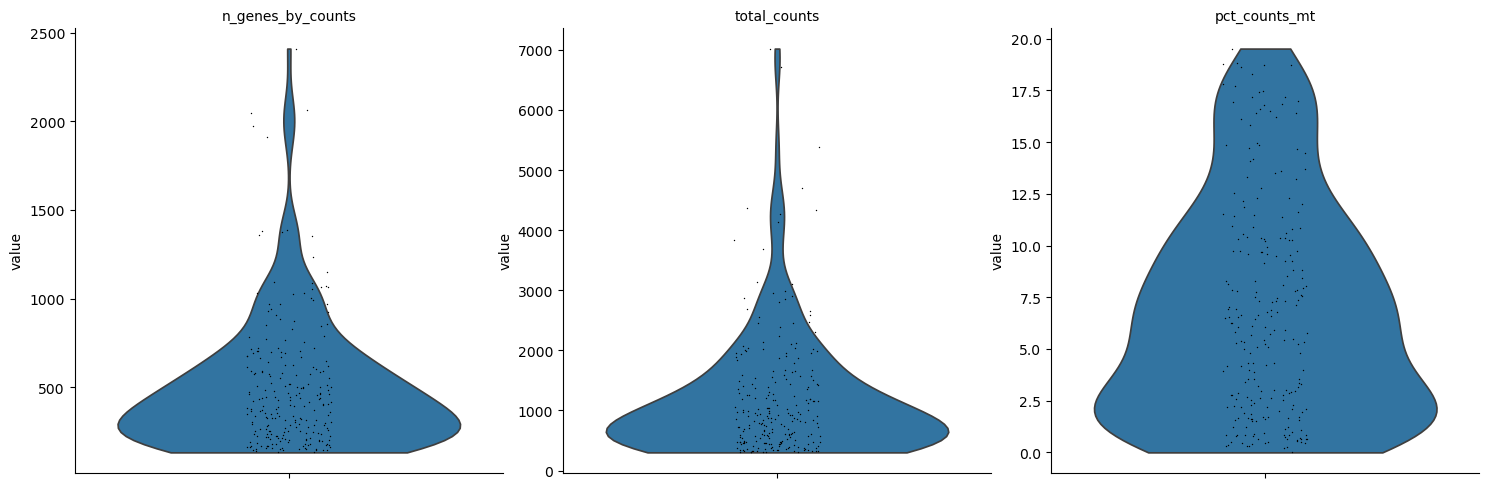

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True)

In [18]:
integrated_adata = ref_adata.concatenate(adata, batch_key='chip', batch_categories=['C03427D4', 'Y00722F7'], join='outer')

/tmp/ipykernel_3713/793156741.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  integrated_adata = ref_adata.concatenate(adata, batch_key='chip', batch_categories=['C03427D4', 'Y00722F7'], join='outer')


In [19]:
integrated_adata.obs.drop(columns=['orig.ident', 'x', 'y'], inplace=True)
integrated_adata.var.drop(columns=[i for i in integrated_adata.var.columns], inplace=True)

In [20]:
integrated_adata.X = integrated_adata.layers['raw']
integrated_adata = normalization(integrated_adata)
integrated_adata = umap(integrated_adata)

In [21]:
sc.external.pp.harmony_integrate(integrated_adata, key='chip')

2024-12-11 14:54:38,167 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-11 14:54:38,270 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-11 14:54:38,321 - harmonypy - INFO - Iteration 1 of 10
2024-12-11 14:54:38,892 - harmonypy - INFO - Iteration 2 of 10
2024-12-11 14:54:39,419 - harmonypy - INFO - Converged after 2 iterations


In [22]:
integrated_adata

AnnData object with n_obs × n_vars = 1132 × 35721
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'n_genes', 'leiden', 'chip'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

In [23]:
sc.pp.neighbors(integrated_adata, use_rep='X_pca_harmony')
sc.tl.umap(integrated_adata)
sc.tl.leiden(integrated_adata, resolution=0.5, n_iterations=-1)

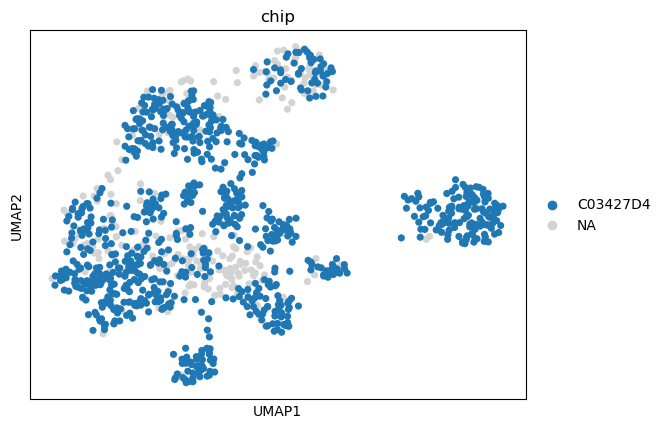

In [24]:
sc.pl.umap(integrated_adata, color='chip', groups='C03427D4')

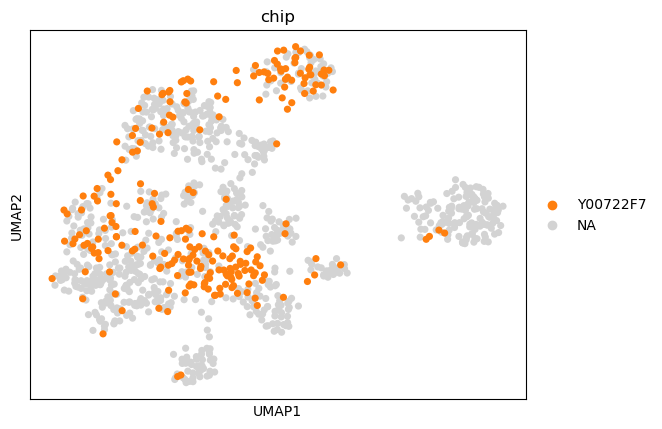

In [25]:
sc.pl.umap(integrated_adata, color='chip', groups='Y00722F7')

In [26]:
sc.tl.leiden(integrated_adata, resolution=1.2, n_iterations=-1)

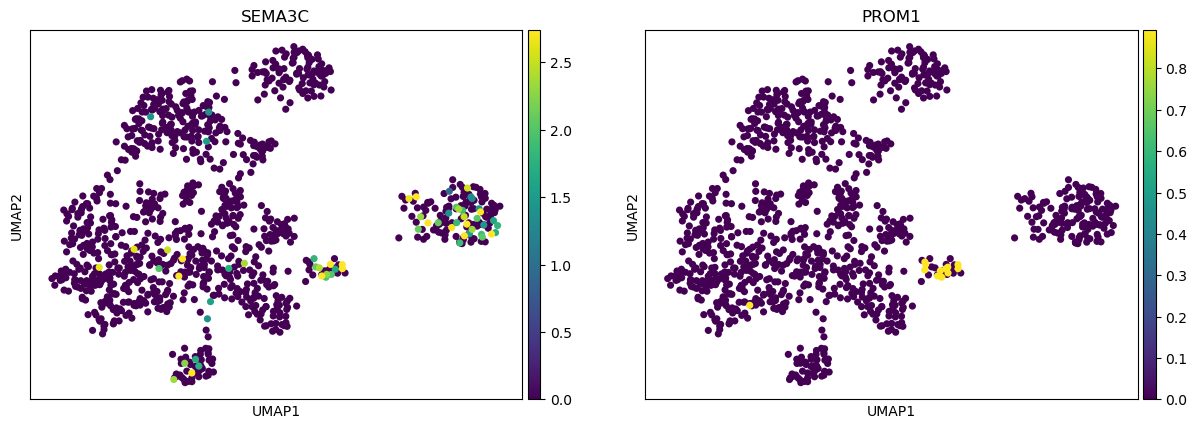

In [27]:
sc.pl.umap(integrated_adata, color=['SEMA3C', 'PROM1'], vmax='p99', vmin='p1')

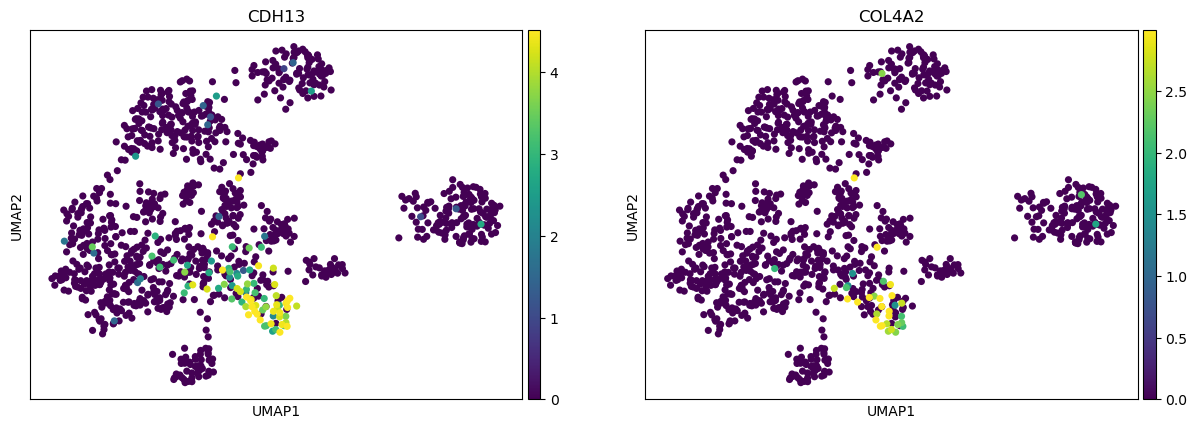

In [28]:
sc.pl.umap(integrated_adata, color=['CDH13', 'COL4A2'], vmax='p99', vmin='p1')

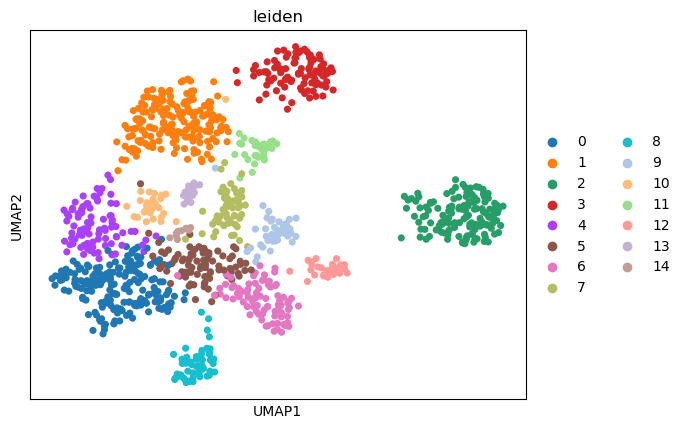

In [29]:
sc.pl.umap(integrated_adata, color='leiden')

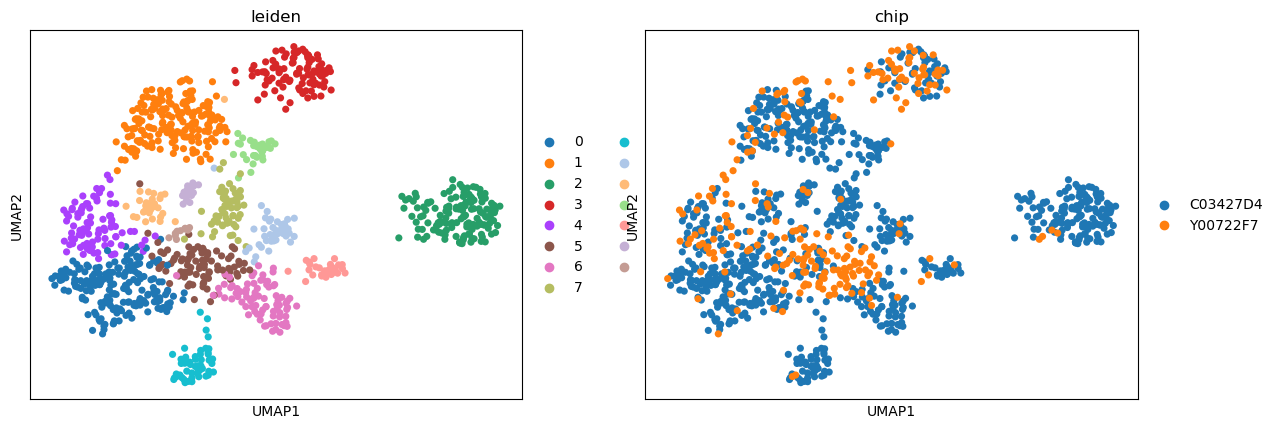

In [30]:
sc.pl.umap(integrated_adata, color=['leiden', 'chip'], vmax='p99', vmin='p1')

In [31]:
sc.tl.rank_genes_groups(integrated_adata, "leiden", method="wilcoxon")

In [32]:
pd.DataFrame(integrated_adata.uns["rank_genes_groups"]["names"]).head(200).to_csv(f"integrated_marker_genes.csv", index=None)

In [33]:
import decoupler as dc
import hotspot
import matplotlib.pyplot as plt

In [34]:
print(hotspot.__version__)
print(dc.__version__)

1.1.1
1.8.1


In [35]:
from scipy.sparse import csr_matrix

In [36]:
integrated_adata.layers['counts'] = csr_matrix(integrated_adata.layers['raw'])

In [37]:
print(integrated_adata)
sc.pp.filter_genes(integrated_adata, min_cells=1)
print(integrated_adata)

AnnData object with n_obs × n_vars = 1132 × 35721
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'n_genes', 'leiden', 'chip'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'chip_colors', 'leiden_colors', 'rank_genes_groups'
    obsm: 'spatial', 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'raw', 'counts'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 1132 × 26797
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'n_genes', 'leiden', 'chip'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap',

In [38]:
hs = hotspot.Hotspot(
    integrated_adata,
    layer_key ="counts",
    model='danb',
    latent_obsm_key="X_pca",
    umi_counts_obs_key="total_counts"
)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/hotspot/hotspot.py:98: UserWarning: Hotspot will work faster when counts are a csc sparse matrix.
  warnings.warn(


In [39]:
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30)
hs_results = hs.compute_autocorrelations()
hs_genes = hs_results.index[hs_results.FDR < 0.05]
hs_genes = hs_genes[:3000]

100%|██████████| 26797/26797 [00:32<00:00, 837.10it/s]


Computing pair-wise local correlation on 3000 features...


100%|██████████| 4498500/4498500 [08:11<00:00, 9155.62it/s] 


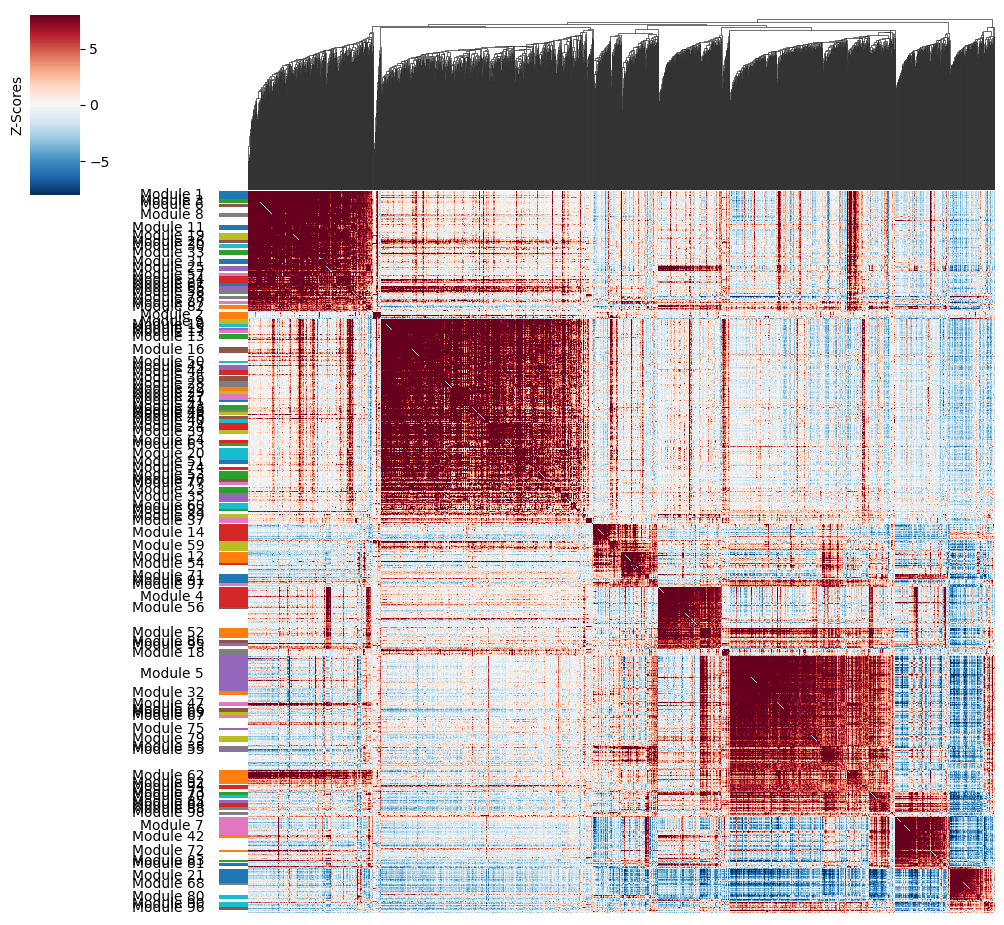

In [42]:
# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=8)
modules = hs.create_modules(min_gene_threshold=10, core_only=True, fdr_threshold=0.05)
hs.plot_local_correlations()

In [50]:
ID = 'integrated'
plt.savefig(f'pca_{ID}_hotspot_module.pdf')


module_scores = hs.calculate_module_scores()
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    integrated_adata.obs[key] = module_scores[c]
    module_cols.append(key)
#with mplscience.style_context():
#    sc.pl.spatial(adata, color=module_cols[:9],  vmin="p0",save = f"_{ID}_modules.pdf", vmax="p99",spot_size=40)
module_scores.to_csv(f'pca_{ID}_module_scores.csv')
results = hs.results.join(hs.modules)
results.to_csv(f"pca_hotspot_{ID}.csv")
sc.set_figure_params(figsize=(4,4),dpi_save=300)
for i in range(1, hs.modules.max()+1):
    print(i)
    sc.pl.umap(integrated_adata, color=module_cols[i-1],  vmin="p1", vmax="p99",show = False, size=100, save = f"pca_spatial_{ID}_{module_cols[i-1]}.png")


Computing scores for 98 modules...


100%|██████████| 98/98 [00:02<00:00, 36.81it/s]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


<Figure size 320x320 with 0 Axes>

<Axes: title={'center': 'Module 37'}, xlabel='UMAP1', ylabel='UMAP2'>

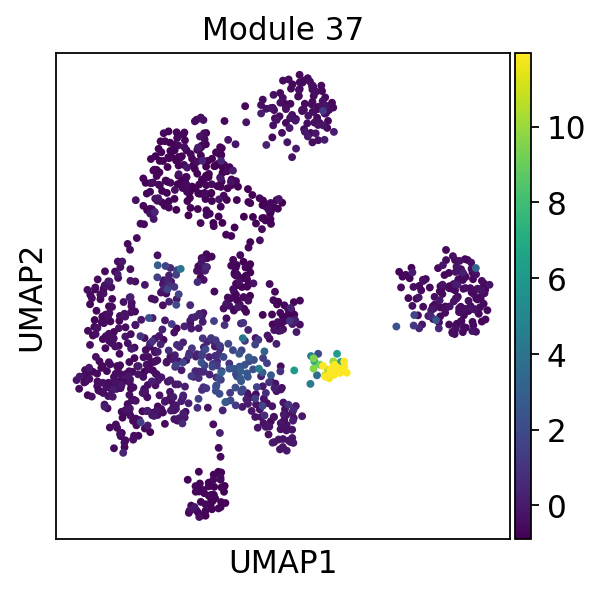

In [52]:
sc.pl.umap(integrated_adata, color=module_cols[36],  vmin="p1", vmax="p99",show = False, size=50)

In [53]:
module_df = pd.read_csv('pca_hotspot_integrated.csv')
module_df.head()

Gene         C           Z  Pval  FDR  Module
0     CDH13  0.487104  401.321866   0.0  0.0     1.0
1     MECOM  0.440701  363.962246   0.0  0.0     1.0
2     PTPRM  0.496601  350.684808   0.0  0.0     1.0
3  KIAA1217  0.422583  332.908992   0.0  0.0     1.0
4     DOCK4  0.442530  329.894573   0.0  0.0     1.0

In [58]:
tmp_df = module_df[(module_df['Module'] == 37) & (module_df['Pval'] < 0.01)]
dge_list = tmp_df['Gene'].tolist()

In [59]:
import gseapy as gp

In [74]:
def enrichment(gene_list, file_name_prefix):
    # enrichment analysis
    enr = gp.enrich(gene_list,
                    gene_sets="GO_Biological_Process_2023",
                    outdir=None)
    # filtering p value is more than 0.05
    result = enr.res2d[enr.res2d['P-value'] < 0.05]
    # save result
    result.to_csv(f"/mnt/c/Users/ouyangkang/Desktop/{file_name_prefix}_result.csv", index=None)

    return result

In [75]:
result = enrichment(dge_list, 'cancer')

In [77]:
result

Gene_set  \
0   GO_Biological_Process_2023   
1   GO_Biological_Process_2023   
2   GO_Biological_Process_2023   
3   GO_Biological_Process_2023   
4   GO_Biological_Process_2023   
..                         ...   
56  GO_Biological_Process_2023   
57  GO_Biological_Process_2023   
58  GO_Biological_Process_2023   
59  GO_Biological_Process_2023   
60  GO_Biological_Process_2023   

                                                 Term Overlap   P-value  \
0   Positive Regulation Of Gap Junction Assembly (...     1/5  0.005986   
1   Renal Filtration Cell Differentiation (GO:0061...     1/5  0.005986   
2   Glomerular Epithelial Cell Differentiation (GO...     1/5  0.005986   
3   Positive Regulation Of Epithelial Cell Differe...     1/5  0.005986   
4           Bradykinin Catabolic Process (GO:0010815)     1/5  0.005986   
..                                                ...     ...       ...   
56    Central Nervous System Development (GO:0007417)   2/283  0.044883   
57  Cyclic-Nucleotide-Mediated Signaling (GO:0019935)    1/40  0.046938   
58             Visual System Development (GO:0150063)    1/41  0.048084   
59  Positive Regulation Of Actin Filament Polymeri...    1/41  0.048084   
60  Regulation Of Neurotransmitter Receptor Activi...    1/42  0.049229   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.094541            0                     0  217.086957   
1           0.094541            0                     0  217.086957   
2           0.094541            0                     0  217.086957   
3           0.094541            0                     0  217.086957   
4           0.094541            0                     0  217.086957   
..               ...          ...                   ...         ...   
56          0.117325            0                     0    6.371724   
57          0.119134            0                     0   22.226310   
58          0.119134            0                     0   21.669565   
59          0.119134            0                     0   21.669565   
60          0.119134            0                     0   21.139979   

    Combined Score          Genes  
0      1111.118048        CNTNAP2  
1      1111.118048          PROM1  
2      1111.118048          PROM1  
3      1111.118048          PROM1  
4      1111.118048            MME  
..             ...            ...  
56       19.775921  CNTNAP2;MEIS1  
57       67.988595         ADGRG6  
58       65.762862          MEIS1  
59       65.762862        CARMIL1  
60       63.658331          NPTX2  

[61 rows x 10 columns]

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


<Axes: title={'center': 'The enrichment pathway in Module 37'}, xlabel='$- \\log_{10}$ (P-value)'>

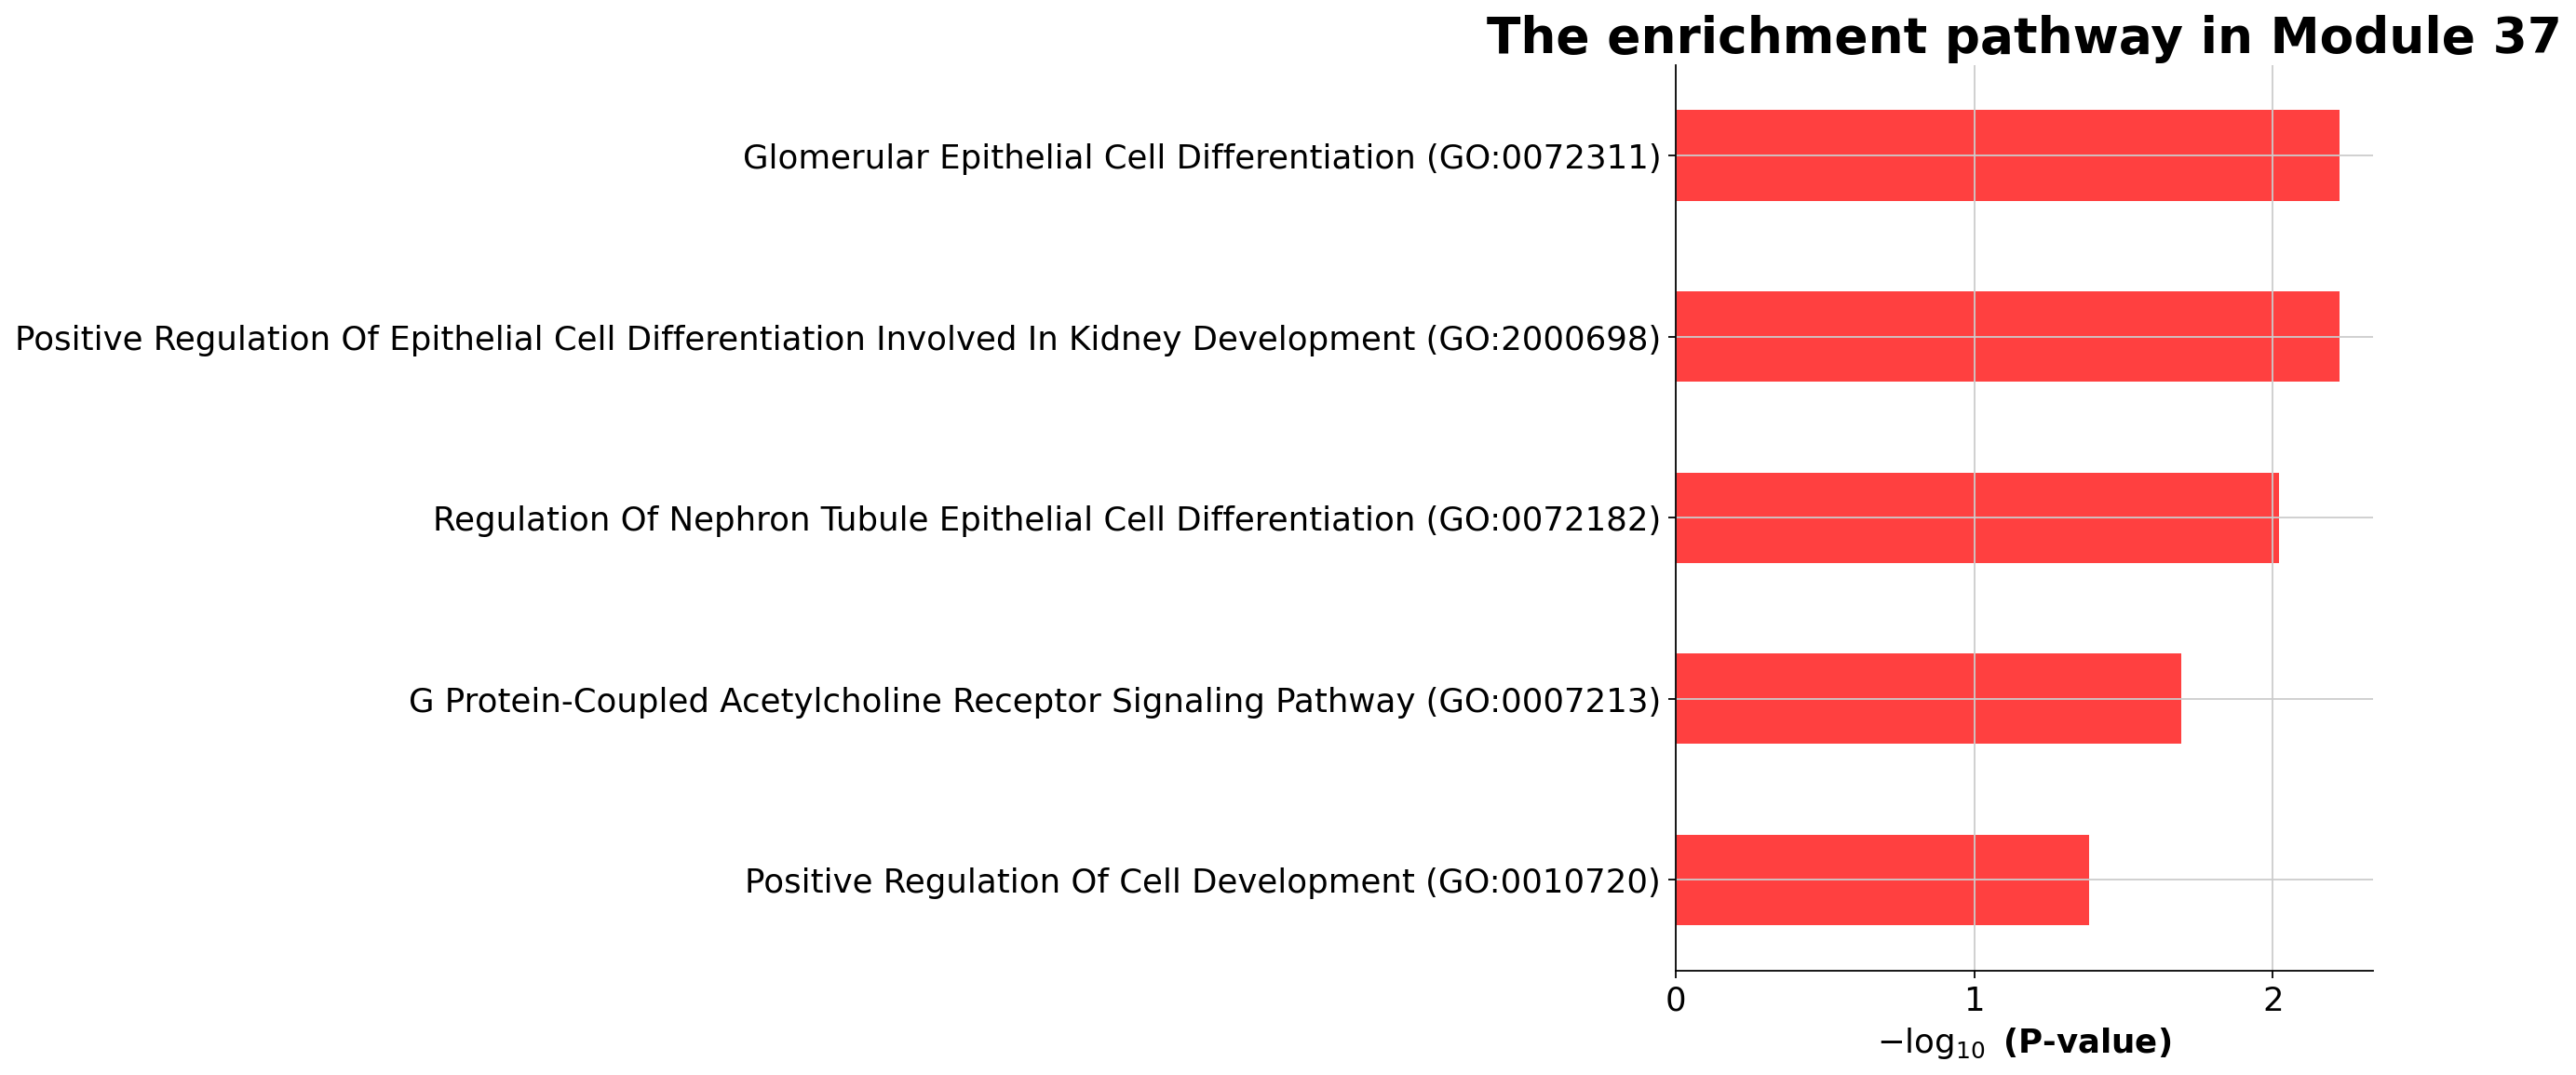

In [78]:
plot_df = result.iloc[[2, 3, 8, 30, 51]]

gp.barplot(
    plot_df,
    figsize=(6, 8),
    title="The enrichment pathway in Module 37",
    color=["r"],
    column="P-value"
)